In [2]:
# Imports and Setup
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, morphology, measure, filters
from skimage.morphology import erosion, disk
from scipy.ndimage import distance_transform_edt
import tifffile
import cc3d
import pandas as pd

# Configuration for visualization
%matplotlib inline
plt.rcParams['figure.figsize'] = (5,4)

def plot_slice(img, title=None):
    import matplotlib.pyplot as plt   
    plt.imshow(img,cmap='gray')
    plt.colorbar()
    if title: plt.title(title)
    plt.show()

## Parameters

In [4]:
slice_idx = 10
radius = 1
thickness = 50
symmetric = True
slope = 3
n_layers = 1

## Load data

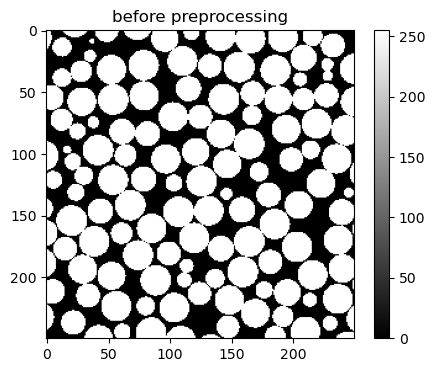

In [6]:
dims = (250, 250, 250)
img_3d = np.fromfile("finney_x250_y250_z250.raw", dtype=np.uint8).reshape(dims)

img_slice = img_3d[:, :, slice_idx]

plot_slice(img_slice,"before preprocessing")

## Preprocessing
- Normalize the image to 0 and 1
- Check porosity and flip if necessary (ensure 0 is pore, 1 is grain)

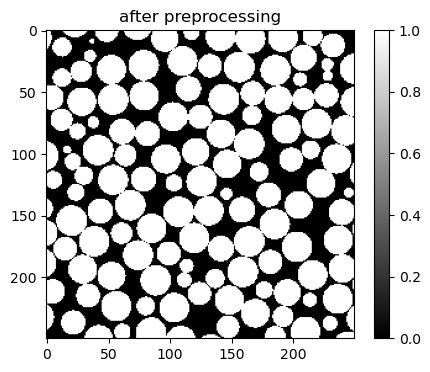

In [8]:
if img_slice.max() > 1:
    img_slice = (img_slice / 255).astype(np.uint8)
else:
    img_slice = img_slice.astype(np.uint8)
    
pore_count = np.sum(img_slice == 0)
grain_count = np.sum(img_slice == 1)

if pore_count > grain_count:
    print("Note: Inverting image to ensure pore=0, grain=1")
    img_slice = 1 - img_slice 

plot_slice(img_slice,"after preprocessing")

## Model Generation

### Erosion

Erosion completed 



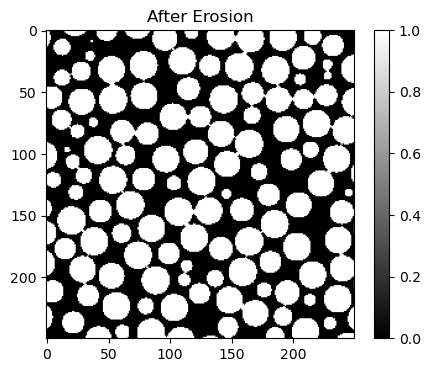

In [10]:
img_slice = erosion(img_slice, disk(radius))
print(f"Erosion completed \n") 

plot_slice(img_slice,"After Erosion")

### Connected component analysis
- Removes small isolated components, keeping only the largest connected component

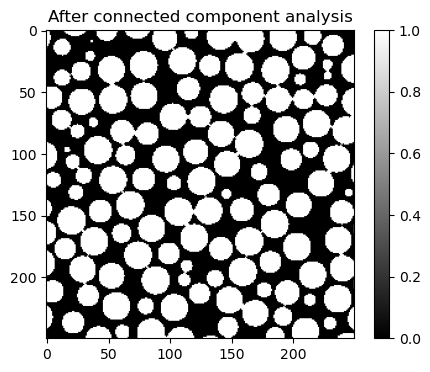

In [12]:
#output: pore=0 grain=1
largest_10_comp, N_10 = cc3d.largest_k(
    1-img_slice, k=10, 
    connectivity=6, delta=0,
    return_N=True,
) 

df = pd.DataFrame(np.unique(largest_10_comp, return_counts=True))
df.columns = ['background'] + [f'comp{i}' for i in range(1, df.shape[1])]
df.index = ['label', 'count']
df = df.T

sorted_df = df.iloc[1:].sort_values(by='count', ascending=False)  # Exclude 'background'
largest_label = sorted_df['label'].iloc[0]
img_slice = largest_10_comp * (largest_10_comp == largest_label)
img_slice = (1-img_slice/largest_label)

plot_slice(img_slice,"After connected component analysis") 

### Compute distance Map
- Calculate the Euclidean distance from the center of a pore to the nearest grain wall

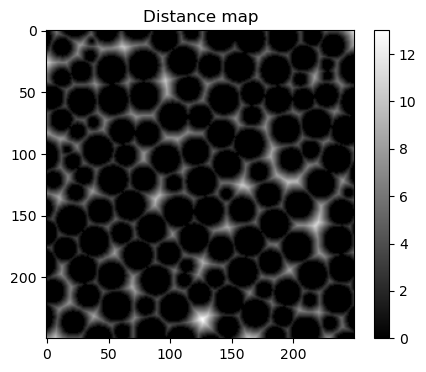

In [14]:
dist_map = distance_transform_edt(1-img_slice) #pore=1, grain=0

plot_slice(dist_map,"Distance map")

### Generate 2D model
Expand dims to (z, y, 1) and repeat along axis 2 (x)

In [16]:
model_2d = np.repeat(img_slice[:, :, np.newaxis], thickness, axis=2) #pore=0, grain=1

### Generate 2.5D Model
Extrudes a 2D slice into a 3D volume based on pore width (distance map)

In [18]:
nz, ny = img_slice.shape
nx = thickness
# Initialize 3D volume with grain(1) pixel, pore=0, grain=1
model_2p5d = np.ones((nz, ny, nx), dtype=np.uint8)

for z in range(nz):
    for y in range(ny):
        if img_slice[z, y] == 0: # Only process pore pixels
            d = dist_map[z, y] * slope
            
            # Clip depth to not exceed model thickness
            h = min(nx, d)
            if not symmetric:
                # One-sided extrusion
                model_2p5d[z, y, 0:h] = 0
            else:
                # Symmetric extrusion (from center)
                center = nx // 2
                half_h = h // 2
                start = int(max(0, center - half_h))
                end = int(min(nx, center + half_h))
                model_2p5d[z, y, start:end] = 0

### Seal boundaries (if needed)
- Adds solid grain layers (value 1) to the Y and Z boundaries

In [20]:
# model_2d = pad_volume(model_2d, n_layers=n_layers)
# model_2p5d = pad_volume(model_2p5d, n_layers=n_layers)

## Visualization

2D model Shape: (250, 250, 50)
2.5D model Shape: (250, 250, 50)


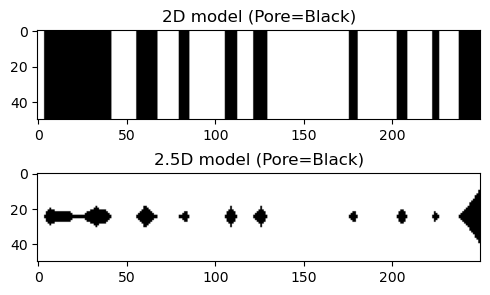

In [22]:
print(f"2D model Shape: {model_2d.shape}")
print(f"2.5D model Shape: {model_2p5d.shape}")

fig, ax = plt.subplots(2, 1, figsize=(5, 3))

ax[0].imshow(np.rot90(model_2d[5,:,:]), cmap='gray')
ax[0].set_title("2D model (Pore=Black)")

ax[1].imshow(np.rot90(model_2p5d[5,:,:]), cmap='gray')
ax[1].set_title("2.5D model (Pore=Black)")

plt.tight_layout()
plt.show()
plt.close()
# Optional: Save
# tifffile.imwrite("output_model.tif", final_model * 255)